# Бинарная классификация изображений с использованием PyTorch

Я буду использовать данные из соревнования по ссылке: 
https://www.kaggle.com/competitions/dogs-vs-cats/overview 

Нам дана папка train, в которой содержатся изображения кошек и собак. Задача построить модель которая будет предсказывать по картинке какое животное на ней изображено, используя метрику F1, применяя аугментации из библиотеки albumentations.

План работы:
- Загрузка и исследование данных, подготовка данных, определи переменных и гиперпараметров модели, разбиение на train, val, test
- Создание трансформации с помощью albumentations, создание загрузчика данных с использованием DataLoader
- Определение модели и функции потерь, обучение модели, определение оптимизатора, цикла для эпох с промежуточным результатом
- Оценка качества модели по F1 на валидации и тестовой выборке. Построение графиков, а так же confusion_matrix

## Загрузка и исследование данных

In [1]:
import torch
import torchvision
import torch.nn as nn
from torchvision.transforms import ToTensor, Resize
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import RandomRotation, RandomResizedCrop, RandomHorizontalFlip, Normalize
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from PIL import Image
from tqdm import tqdm
import cv2
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from matplotlib.image import imread

Определим константы модели:

In [2]:
TRAIN_PATH = "train/"
NUM_BATCH = 64
EPOCHS = 5
LEARNING_RATE = 0.001
RANDOM_STATE = 12345
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

Создаем DataFrame по нашим картинкам:

In [3]:
filenames = os.listdir(TRAIN_PATH)
labels = [x.split(".")[0] for x in filenames]

df = pd.DataFrame({"file_name": filenames, "label": labels})
df.head(5)

,file_name,label
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


Визуально оценим содержимое с чем предстоит работать, сначала собаки, затем кошки:

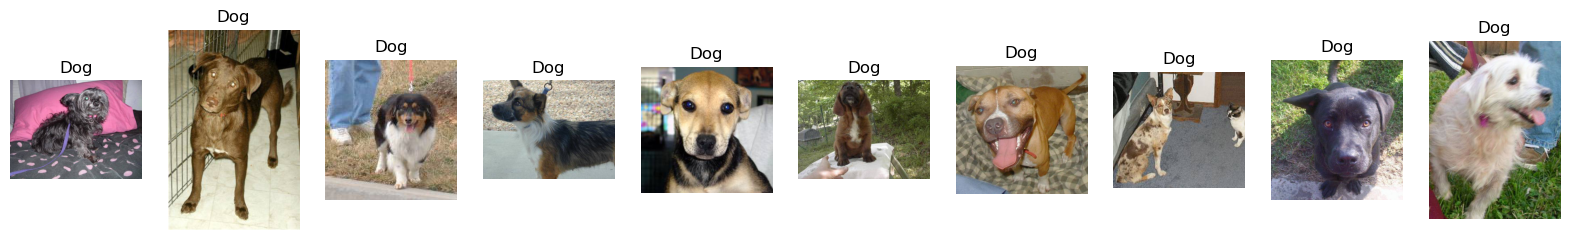

In [4]:
plt.figure(figsize=(20,20)) 
for n in range(0,10):    
    plt.subplot(1,10,n+1)    
    name = 'train/'+'dog.'+str(n)+'.jpg'
    image = imread(name)
    plt.imshow(image)
    plt.title('Dog')
    plt.axis('off')
plt.show()

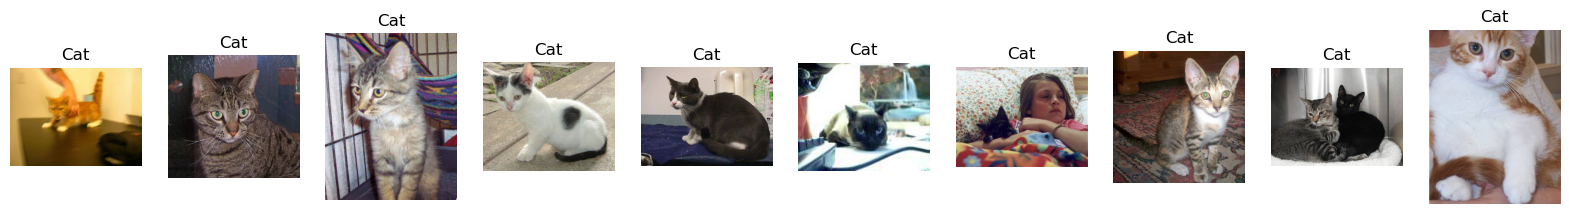

In [5]:
plt.figure(figsize=(20,20)) 
for n in range(0,10):    
    plt.subplot(1,10,n+1)    
    name = 'train/'+'cat.'+str(n)+'.jpg'
    image = imread(name)
    plt.imshow(image)
    plt.title('Cat')
    plt.axis('off')
plt.show()

Я вижу, что изображения имеют разный размер, так же на некоторых видны люди. Еще есть изображения, где несколько животных, а так же есть картинки где и кошки и собаки.

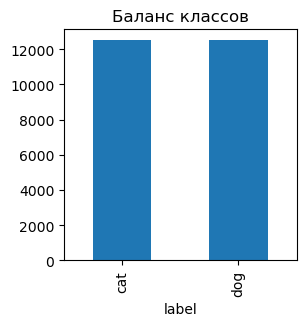

In [6]:
plt.figure(figsize=(3,3))
df['label'].value_counts().plot.bar()
plt.title('Баланс классов')
plt.show()

Хорошо видно что целевая метка распределна равномерно. 

## Предобработка и подготовка данных 

Создадим список со всеми изображениями и разобьем их на тренировочную , валидационную и тестовую выборки по 70%, 15%, 15% соотвественно:

In [7]:
all_images = os.listdir(TRAIN_PATH)

train_images, test_val_images = train_test_split(all_images, test_size=0.3, random_state=RANDOM_STATE)
test_images, val_images = train_test_split(test_val_images, test_size=0.5, random_state=RANDOM_STATE)

print(len(train_images))
print(len(test_images))
print(len(val_images))

17500
3750
3750


Создадим класс, который последовательно применит функции для чтения изображений, извлечения меток классов и примененит преобразование данных:

In [8]:
class CatDogDataset(Dataset):
    def __init__(self, train_dir, transform=None, images=None):
        self.train_dir = train_dir
        self.transform = transform
        self.images = os.listdir(train_dir) if images is None else images
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = os.path.join(self.train_dir, self.images[index])
        label = self.images[index].split(".")[0]
        label = 0 if label == 'cat' else 1
        image = Image.open(image_path)
        
        if self.transform is not None:
            augmented = self.transform(image=np.array(image))
            image = augmented['image']
        
        return image, label

Ниже мы определим три набора преобразований для изображений: train_transform, val_transform и test_transform.
Каждый из наборов преобразований состоит из нескольких шагов, таких как изменение размера, центральное обрезание, поворот, горизонтальное и вертикальное отражение, различные операции с цветом, нормализация значений пикселей и конвертация в тензор.
Эти преобразования используются для обработки и подготовки данных обучающего, валидационного и тестового набора изображений перед использованием их в модели машинного обучения.

В данном случае, мною были выбраны следующие аугментации с использованием albumentations:
- A.Resize и A.CenterCrop эти преобразования используются для стандартизации размера изображений. Я тестировал разные размеры, но мне с текущими данными лучше всего подошел размер (256x256), а затем вырезание центральных квадратных областей фиксированного размера (224x224) с помощью CenterCrop.
- A.Rotate, A.HorizontalFlip, и A.VerticalFlip эти аугментации увеличивают разнообразие данных путем внесения некоторого искажения в изображения. Я так же пытался поставить разный угол поворота, так же тестировал разные вероятности поворота. В данном примере выбраны случайные повороты до 20 градусов (Rotate), случайные горизонтальные отражения (HorizontalFlip) с вероятностью 0.4 и случайные вертикальные отражения (VerticalFlip) с вероятностью 0.1. Такое разнообразие позволяет модели лучше обобщать и делает ее устойчивее к возможным искажениям в реальном мире.
- A.RandomBrightness, A.RandomGamma, A.GaussNoise добавлены аугментации, случайное изменение яркости, случайное изменение гаммы, и добавление гауссовского шума.
- А.OneOf это преобразование выбирает одно из двух преобразований (размытие или изменение цвета) с равными вероятностями. Размытие (Blur) помогает сгладить некоторые детали изображения, что может уменьшить переобучение модели. Изменение цвета (ColorJitter) позволяет модели учиться на различных цветовых схемах и свойствах изображений. Это позволяет улучшить обобщение модели и повысить ее устойчивость к изменениям в цветовой гамме изображений.
- А.Normalize это преобразование нормализует значения пикселей изображений. Нормализация при помощи средних значений и стандартных отклонений позволяет центрировать и масштабировать значения пикселей таким образом, чтобы они имели среднее значение 0 и стандартное отклонение 1. Это важно для работы с моделями машинного обучения, так как позволяет добиться стабильности и согласованности входных данных.

Я пытался использовать еще больше аугментаций, но они ухудшали качество модели. Тот набор, который содержится в модели с теми параметрами, которые содержатся в аугментациях - это лучшее что я смог подобрать за отведенное время. Так же я читал сатитьи на эту тему и изучал коды других исполнителей по этой задаче. 

In [9]:
train_transform = A.Compose([
    A.Resize(width=256, height=256),
    A.RandomCrop(width=224, height=224),
    A.Rotate(limit=20, p=0.9, border_mode=cv2.BORDER_CONSTANT),
    A.HorizontalFlip(p=0.4),
    A.VerticalFlip(p=0.1),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.5),
    A.GaussNoise(p=0.5),
    A.OneOf([
        A.Blur(blur_limit=4, p=0.5),
        A.ColorJitter(p=1.0),
    ]),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(width=256, height=256),
    A.CenterCrop(width=224, height=224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(width=256, height=256),
    A.CenterCrop(width=224, height=224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

Инициализируем и создадим наборы данных train_data, val_data, test_data и загрузчики данных train_dl, val_dl, test_dl для обучения, валидации и тестирования модели машинного обучения.

In [10]:
train_data = CatDogDataset(TRAIN_PATH, transform=train_transform, images=train_images)
val_data = CatDogDataset(TRAIN_PATH, transform=val_transform, images=val_images)
test_data = CatDogDataset(TRAIN_PATH, transform=test_transform, images=test_images)

train_dl = DataLoader(train_data, batch_size=NUM_BATCH, shuffle=True)
val_dl = DataLoader(val_data, batch_size=NUM_BATCH)
test_dl = DataLoader(test_data, batch_size=NUM_BATCH)

Создаем модель машинного обучения на основе предварительно обученной модели ResNet-18, замораживаем градиенты для всех параметров модели, изменяем последний слой модели для классификации на два класса, определяем функцию потерь и оптимизатор для обучения модели с помощью алгоритма оптимизации Adam.

In [11]:
model = torchvision.models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(
    nn.Linear(in_features=512, out_features=2),
    nn.Softmax(dim=1)
)

model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=LEARNING_RATE)

C:\Users\Artem\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Artem\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Ниже я определю несколько вспомогательных функций для вычисления метрики F1, создания графика метрик, вычисления метрик и лосса на валидации и тесте

In [12]:
# функция для вычисления метрики F1
def f1_score(preds, targets):
    preds = preds.argmax(dim=1)
    tp = (preds * targets).sum().float()
    tn = ((1 - preds) * (1 - targets)).sum().float()
    fp = (preds * (1 - targets)).sum().float()
    fn = ((1 - preds) * targets).sum().float()
    epsilon = 1e-7
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)
    return f1.item()

# функция для создания графика метрик
def plot_metrics(train_metric, val_metric, train_loss, val_loss):
    epochs = range(1, len(train_metric) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_metric, 'b-o', label='Обучение F1')
    plt.plot(epochs, val_metric, 'r-o', label='Валидация F1')
    plt.title('Обучение и Валидация F1')
    plt.xlabel('Эпоха')
    plt.ylabel('F1')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'b-o', label='Обучение Loss')
    plt.plot(epochs, val_loss, 'r-o', label='Валидация Loss')
    plt.title('Обучение и Валидация Loss')
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# функция для вычисления метрик и лосса на валидации и тесте
def evaluate(model, data_loader, device):
    model.eval()
    loss = 0.0
    f1 = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss += criterion(outputs, labels).item()
            f1 += f1_score(outputs, labels)

            preds = outputs.argmax(dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    loss /= len(data_loader)
    f1 /= len(data_loader)

    return loss, f1, all_labels, all_preds

## Обучение модели и оценка производительности

Начнем обучать модель и выведем на экран ее метрики по каждой эпохе обучения на тренировачных и валидационных данных:

In [13]:
train_loss_history = []
val_loss_history = []
train_f1_history = []
val_f1_history = []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    train_f1 = 0.0

    for images, labels in tqdm(train_dl):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_f1 += f1_score(outputs, labels)

    train_loss /= len(train_dl)
    train_f1 /= len(train_dl)

    train_loss_history.append(train_loss)
    train_f1_history.append(train_f1)

    val_loss, val_f1, val_labels, val_preds = evaluate(model, val_dl, DEVICE)

    val_loss_history.append(val_loss)
    val_f1_history.append(val_f1)

    print(f'Эпоха [{epoch+1}/{EPOCHS}], Обучение Loss: {train_loss:.4f}, Обучение F1: {train_f1:.4f}, Валидация Loss: {val_loss:.4f}, Валидация F1: {val_f1:.4f}')

100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:55<00:00,  1.06it/s]


Эпоха [1/5], Обучение Loss: 0.4156, Обучение F1: 0.9123, Валидация Loss: 0.3435, Валидация F1: 0.9774


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:56<00:00,  1.04it/s]


Эпоха [2/5], Обучение Loss: 0.3780, Обучение F1: 0.9396, Валидация Loss: 0.3411, Валидация F1: 0.9740


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:56<00:00,  1.04it/s]


Эпоха [3/5], Обучение Loss: 0.3716, Обучение F1: 0.9425, Валидация Loss: 0.3407, Валидация F1: 0.9718


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:55<00:00,  1.05it/s]


Эпоха [4/5], Обучение Loss: 0.3699, Обучение F1: 0.9440, Валидация Loss: 0.3353, Валидация F1: 0.9786


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:55<00:00,  1.07it/s]

Эпоха [5/5], Обучение Loss: 0.3687, Обучение F1: 0.9449, Валидация Loss: 0.3359, Валидация F1: 0.9777


По эпохам мы можем увидеть, что результат Валидация F1: 0.9774 на первой же эпохе показал практически лучший результат. Это говорит о том, что применяемые аугментации показывают высокую эффективность и выборки хватает для принятия качесвтенных решений. Валидация Loss на каждом шаге становилась все лучше и лучше. 

Создание графиков и оценка модели на тестовых данных:

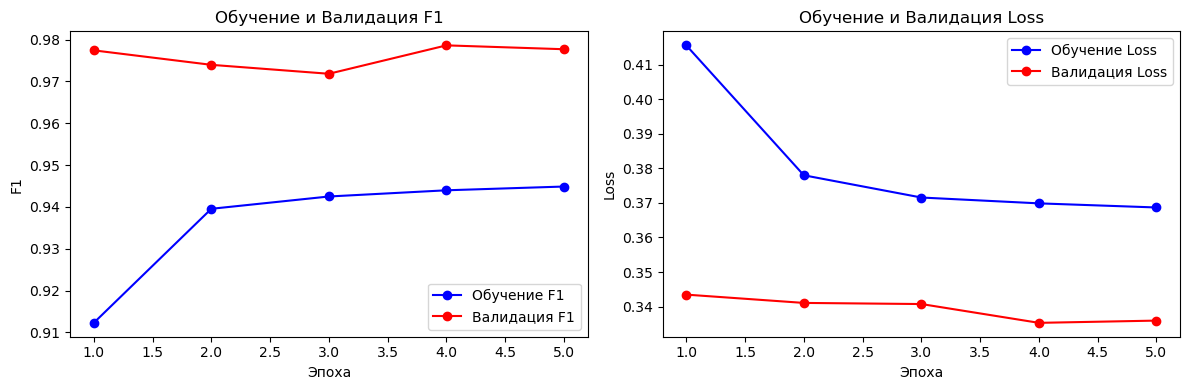

100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:55<00:00,  1.07it/s]

Тестовые Loss: 0.3357, Тестовые F1: 0.9775


In [14]:
plot_metrics(train_f1_history, val_f1_history, train_loss_history, val_loss_history)

test_loss, test_f1, test_labels, test_preds = evaluate(model, test_dl, DEVICE)
print(f'Тестовые Loss: {test_loss:.4f}, Тестовые F1: {test_f1:.4f}')

Итоговые Тестовые Loss: 0.3357, Тестовые F1: 0.9775 показывают достаточно высокую эффективность и обобщающую способность модели решать задачу бинарной классификации. 

На графиках наглядно видно как проходило обучение модели и измерение ее промежуточных результатов описанных выше.

Матрица ошибок для валидационных данных:

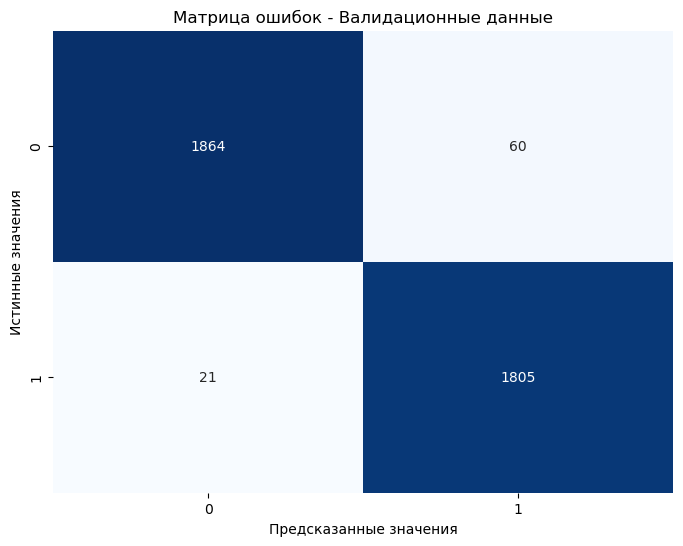

In [15]:
val_cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(val_cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.title('Матрица ошибок - Валидационные данные')
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.show()

Матрица ошибок для тестовых данных:

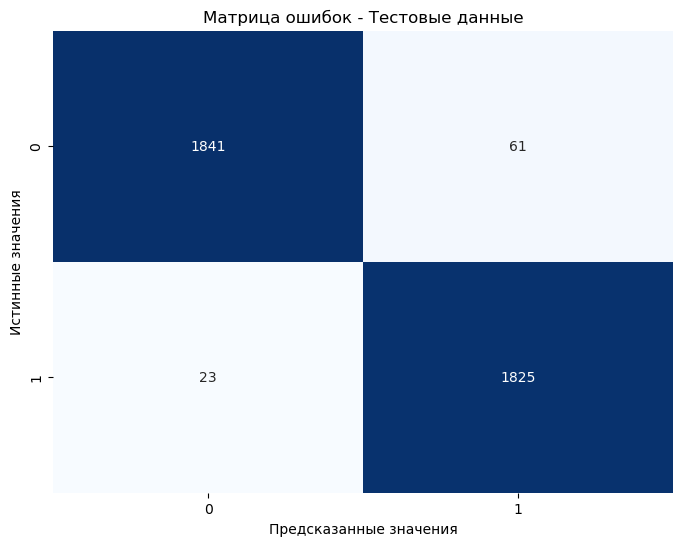

In [16]:
test_cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.title('Матрица ошибок - Тестовые данные')
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.show()

Значение 0 это кошки, а 1 - собаки. На матрицах ошибок видно, что ошибки на валидационной и тестовой выборках правктически совпадают в точности по количеству, что говорит о хорошо подобранных выборках и хорошей обобщающей способности модели. Она не переобучена и не недоучена. 
Для кошек полнота составляет около 0.9675, а точность - около 0.9877. Для собак полнота составляет около 0.9879, а точность - около 0.9677.

# Общий вывод

Нам была дана папка train, в которой содержатся изображения кошек и собак. Задача была построить модель которая будет предсказывать по картинке какое животное на ней изображено, используя метрику F1, применяя аугментации из библиотеки albumentations.

Мы следовали плану:
- Загрузка и исследование данных, подготовка данных, определи переменных и гиперпараметров модели, разбиение на train, val, test
- Создание трансформации с помощью albumentations, создание загрузчика данных с использованием DataLoader
- Определение модели и функции потерь, обучение модели, определение оптимизатора, цикла для эпох с промежуточным результатом
- Оценка качества модели по F1 на валидации и тестовой выборке. Построение графиков, а так же confusion_matrix

Начали работу с загрузки данных и их исследования. Я отметил, что изображения имеют разный размер, так же на некоторых видны люди. Еще есть изображения, где несколько животных, а так же есть картинки где и кошки и собаки. Так же я построил гистрограмму, на которой видно баланс классов. 

Затем мы занялись предобработкой и подготовкой данных. Разбили изображения на тренировочную , валидационную и тестовую выборки по 70%, 15%, 15% соотвественно, создали класс, который последовательно применял преобразование данных. В данном случае, мною были выбраны следующие аугментации с использованием albumentations:
- A.Resize и A.CenterCrop эти преобразования используются для стандартизации размера изображений. Я тестировал разные размеры, но мне с текущими данными лучше всего подошел размер (256x256), а затем вырезание центральных квадратных областей фиксированного размера (224x224) с помощью CenterCrop.
- A.Rotate, A.HorizontalFlip, и A.VerticalFlip эти аугментации увеличивают разнообразие данных путем внесения некоторого искажения в изображения. Я так же пытался поставить разный угол поворота, так же тестировал разные вероятности поворота. В данном примере выбраны случайные повороты до 20 градусов (Rotate), случайные горизонтальные отражения (HorizontalFlip) с вероятностью 0.4 и случайные вертикальные отражения (VerticalFlip) с вероятностью 0.1. Такое разнообразие позволяет модели лучше обобщать и делает ее устойчивее к возможным искажениям в реальном мире.
- A.RandomBrightness, A.RandomGamma, A.GaussNoise добавлены аугментации, случайное изменение яркости, случайное изменение гаммы, и добавление гауссовского шума.
- А.OneOf это преобразование выбирает одно из двух преобразований (размытие или изменение цвета) с равными вероятностями. Размытие (Blur) помогает сгладить некоторые детали изображения, что может уменьшить переобучение модели. Изменение цвета (ColorJitter) позволяет модели учиться на различных цветовых схемах и свойствах изображений. Это позволяет улучшить обобщение модели и повысить ее устойчивость к изменениям в цветовой гамме изображений.
- А.Normalize это преобразование нормализует значения пикселей изображений. Нормализация при помощи средних значений и стандартных отклонений позволяет центрировать и масштабировать значения пикселей таким образом, чтобы они имели среднее значение 0 и стандартное отклонение 1. Это важно для работы с моделями машинного обучения, так как позволяет добиться стабильности и согласованности входных данных.

Я пытался использовать еще больше аугментаций, но они ухудшали качество модели. Тот набор, который содержится в модели с теми параметрами, которые содержатся в аугментациях - это лучшее что я смог подобрать за отведенное время. Так же я читал сатитьи на эту тему и изучал коды других исполнителей по этой задаче. 

Затем я создал модель машинного обучения на основе предварительно обученной модели ResNet-18 и обучил ее, определил функцию потерь и оптимизатор для обучения модели с помощью алгоритма оптимизации Adam.

Я вывел на экран метрики loss и F1 по каждой эпохе обучения на тренировачных и валидационных данных:
- Эпоха [1/5], Обучение Loss: 0.4156, Обучение F1: 0.9123, Валидация Loss: 0.3435, Валидация F1: 0.9774
- Эпоха [2/5], Обучение Loss: 0.3780, Обучение F1: 0.9396, Валидация Loss: 0.3411, Валидация F1: 0.9740
- Эпоха [3/5], Обучение Loss: 0.3716, Обучение F1: 0.9425, Валидация Loss: 0.3407, Валидация F1: 0.9718
- Эпоха [4/5], Обучение Loss: 0.3699, Обучение F1: 0.9440, Валидация Loss: 0.3353, Валидация F1: 0.9786
- Эпоха [5/5], Обучение Loss: 0.3687, Обучение F1: 0.9449, Валидация Loss: 0.3359, Валидация F1: 0.9777

По эпохам мы можем увидеть, что результат Валидация F1: 0.9774 на первой же эпохе показал практически лучший результат. Это говорит о том, что применяемые аугментации показывают высокую эффективность и выборки хватает для принятия качесвтенных решений. Валидация Loss на каждом шаге становилась все лучше и лучше. 


Итоговые Тестовые Loss: 0.3357, Тестовые F1: 0.9775 показывают достаточно высокую эффективность и обобщающую способность модели решать задачу бинарной классификации. 

На матрицах ошибок видно, что ошибки на валидационной и тестовой выборках правктически совпадают в точности по количеству, что говорит о хорошо подобранных выборках и хорошей обобщающей способности модели. Она не переобучена и не недоучена. 
Для кошек полнота составляет около 0.9675, а точность - около 0.9877. Для собак полнота составляет около 0.9879, а точность - около 0.9677.